## PySCF with OpenFermion

Oxygen bond length optimisation

Based on the example from:

[https://github.com/quantumlib/OpenFermion-PySCF](https://github.com/quantumlib/OpenFermion-PySCF)

[https://quantumai.google/openfermion/tutorials](https://quantumai.google/openfermion/tutorials)

In [1]:
import io
from ase.io.xyz import write_xyz
from ase.visualize import view
from ase.build import molecule
atoms = molecule('H2')
view(atoms, viewer='x3d')

In [2]:
def create_molecule(bond_length: float):
    f = io.StringIO()
    atoms[0].c=0.
    atoms[1].c=bond_length
    atoms.write(f,format='xyz')
    return [(a.split()[0],(float(a.split()[1]),float(a.split()[2]),float(a.split()[3]))) for a in f.getvalue().split('\n')[2:-1]]


At bond length of 0.7250000000000001 angstrom, molecular hydrogen has:
Hartree-Fock energy of -1.1173432691225826 Hartree.


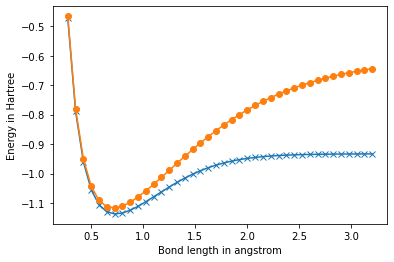

In [3]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 40
bond_length_interval = 3.0 / n_points

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
best_bond_length=None
best_hf_energy=None
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point) + 0.2
    bond_lengths += [bond_length]
    geometry = create_molecule(bond_length)
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run pyscf.
    molecule = run_pyscf(molecule,
                         run_scf=run_scf,
                         run_mp2=run_mp2,
                         run_cisd=run_cisd,
                         run_ccsd=run_ccsd,
                         run_fci=run_fci)

    # Print out some results of calculation.
    #print(f'\nAt bond length of {bond_length} angstrom, molecular oxygen has:')
    #print(f'Hartree-Fock energy of {molecule.hf_energy} Hartree.')
    #print(f'MP2 energy of {molecule.mp2_energy} Hartree.')
    #print(f'FCI energy of {molecule.fci_energy} Hartree.')
    #print(f'Nuclear repulsion energy between protons is {molecule.nuclear_repulsion} Hartree.')
    #for orbital in range(molecule.n_orbitals):
    #    print(f'Spatial orbital {orbital} has energy of {molecule.orbital_energies[orbital]} Hartree.')
    
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]
    
    if not best_bond_length:
        best_bond_length = bond_length
        best_hf_energy = molecule.hf_energy
    elif best_hf_energy > molecule.hf_energy:
        best_hf_energy = molecule.hf_energy
        best_bond_length = bond_length
        

print(f'\nAt bond length of {best_bond_length} angstrom, molecular hydrogen has:')
print(f'Hartree-Fock energy of {best_hf_energy} Hartree.')
        
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [8]:
h2_molecule=molecule
one_body_integrals=h2_molecule.one_body_integrals
one_body_integrals

array([[-6.37998834e-01, -5.55111512e-17],
       [-5.55111512e-17, -6.25755328e-01]])

In [10]:
from openfermion.transforms import get_fermion_operator, jordan_wigner
h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(h2_molecule.get_molecular_hamiltonian()))
h2_qubit_hamiltonian

(-0.5457027600160764+0j) [] +
(-0.0761659522196264+0j) [X0 X1 Y2 Y3] +
(0.0761659522196264+0j) [X0 Y1 Y2 X3] +
(0.0761659522196264+0j) [Y0 X1 X2 Y3] +
(-0.0761659522196264+0j) [Y0 Y1 X2 X3] +
(0.0434369665107613+0j) [Z0] +
(0.11673496462785363+0j) [Z0 Z1] +
(0.04133076681419715+0j) [Z0 Z2] +
(0.11749671903382355+0j) [Z0 Z3] +
(0.04343696651076131+0j) [Z1] +
(0.11749671903382355+0j) [Z1 Z2] +
(0.04133076681419715+0j) [Z1 Z3] +
(0.03575659087073407+0j) [Z2] +
(0.11829358734169143+0j) [Z2 Z3] +
(0.035756590870734045+0j) [Z3]

In [17]:
from openfermion.linalg import get_sparse_operator
from scipy.linalg import eigh

h2_matrix = get_sparse_operator(h2_qubit_hamiltonian).todense()
eighgenvalues, eigenvectors = eigh(h2_matrix)

array([-0.93337998, -0.93306322, -0.93306322, -0.93306322, -0.63413532,
       -0.63413532, -0.61565732, -0.61565732, -0.47263096, -0.47263096,
       -0.46038745, -0.46038745, -0.3237356 , -0.32327838, -0.15140635,
        0.16536788])

In [44]:
import cirq
from openfermion.circuits import simulate_trotter
from openfermion.circuits.trotter import LOW_RANK


hamiltonian = h2_molecule.get_molecular_hamiltonian()
qubits = cirq.LineQubit.range(4)
circuit = cirq.CircuitDag.from_ops(
    simulate_trotter(
        qubits,
        hamiltonian,
        time=1.0,
        n_steps=1,
        order=0,
        algorithm=LOW_RANK,
        omit_final_swaps=True
    )
)

#cirq.merge_single_qubit_gates_into_phxz(circuit)

#cirq.merge_single_qubit_gates_into_phased_x_z(circuit)


circuit.to_circuit()

0: ───Rz(0)───Rz(0.326π)───Rz(0)──────────────────────PhISwap(0.25)────────────────────────────────────────────@──────────×────────────────────────────@─────────×───Rz(-0.074π)───Rz(π)────────────────────────────────────────────────────────────────PhISwap(0.25)────────Z^0───────────────────────────@──────────×─────────────────@─────────×───Rz(-0.048π)───Rz(0)────────────────────────────────────────────PhISwap(0.25)───────────────────────────────────────────────@─────×───────────────────@─────×───Rz(0)───Rz(-π)────────────────────
                                                      │                                                        │          │                            │         │                                                                                      │                                                  │          │                 │         │                                                                  │                                                           │     │                   │     │
1: ───Rz(0)───Rz(0.326π)───Rz(0)───PhISwap(0.25)──────PhISwap(0.25)^-1───Z^0────────────────PhISwap(0.25)──────@^-0.151───×──────────────@─────────×───@^-0.15───×───@─────────────×───────Rz(-0.074π)───Rz(0)───PhISwap(0.25)──────Z^0─────────────────PhISwap(0.25)^-0.5───PhISwap(0.25)──────Z^0────────@^-0.097───×───@─────────×───@^0.097───×───@─────────────×───────Rz(-0.048π)───Rz(π)───PhISwap(0.25)──────PhISwap(0.25)^-0.5───Z^0─────────────────PhISwap(0.25)──────@^0───×─────────@─────×───@^0───×───@───────×────────Rz(0)───Rz(-π)───
                                   │                                                        │                                            │         │                 │             │                             │                                                           │                                            │         │                 │             │                             │                                                           │                                  │     │             │       │
2: ───Rz(0)───Rz(0.323π)───Rz(0)───PhISwap(0.25)^-1───Z^0────────────────PhISwap(0.25)──────PhISwap(0.25)^-1───Z^0────────@──────────×───@^-0.15───×───@─────────×───@^-0.15───────×───────Rz(-0.075π)───Rz(0)───PhISwap(0.25)^-1───PhISwap(0.25)───────Z^0──────────────────PhISwap(0.25)^-1───@──────────×──────────────@^0.097───×───@─────────×───@^0.097───────×───────Rz(-0.048π)───Rz(0)───PhISwap(0.25)^-1───Z^0──────────────────PhISwap(0.25)───────PhISwap(0.25)^-1───Z^0───@─────×───@^0───×───@─────×───@^0─────×────────Rz(0)───Rz(-π)───
                                                                         │                                                │          │                 │         │                                                                  │                                                           │          │                            │         │                                                                                       │                                            │     │             │     │
3: ───Rz(0)───Rz(0.323π)───Rz(0)─────────────────────────────────────────PhISwap(0.25)^-1───Z^0───────────────────────────@^-0.149───×─────────────────@^-0.15───×───Rz(-0.075π)───Rz(π)────────────────────────────────────────────PhISwap(0.25)^0.5───────────────────────────────────────────@^-0.097───×────────────────────────────@^0.097───×───Rz(-0.048π)───Rz(π)─────────────────────────────────────────────────────────────────PhISwap(0.25)^0.5───Z^0──────────────────────@^0───×─────────────@^0───×───Rz(0)───Rz(-π)────────────────────

In [46]:
import openfermion

hamiltonian = h2_molecule.get_molecular_hamiltonian()
print(openfermion.get_fermion_operator(hamiltonian))

0.1653678784125 [] +
-0.6379988339732712 [0^ 0] +
0.23346992925570725 [0^ 0^ 0 0] +
0.1523319044392528 [0^ 0^ 2 2] +
0.23346992925570725 [0^ 1^ 1 0] +
0.1523319044392528 [0^ 1^ 3 2] +
0.1523319044392528 [0^ 2^ 0 2] +
0.23499343806764708 [0^ 2^ 2 0] +
0.1523319044392528 [0^ 3^ 1 2] +
0.23499343806764708 [0^ 3^ 3 0] +
0.23346992925570725 [1^ 0^ 0 1] +
0.1523319044392528 [1^ 0^ 2 3] +
-0.6379988339732712 [1^ 1] +
0.23346992925570725 [1^ 1^ 1 1] +
0.1523319044392528 [1^ 1^ 3 3] +
0.1523319044392528 [1^ 2^ 0 3] +
0.23499343806764708 [1^ 2^ 2 1] +
0.1523319044392528 [1^ 3^ 1 3] +
0.23499343806764708 [1^ 3^ 3 1] +
0.2349934380676471 [2^ 0^ 0 2] +
0.1523319044392528 [2^ 0^ 2 0] +
0.2349934380676471 [2^ 1^ 1 2] +
0.1523319044392528 [2^ 1^ 3 0] +
-0.6257553281208923 [2^ 2] +
0.1523319044392528 [2^ 2^ 0 0] +
0.23658717468338286 [2^ 2^ 2 2] +
0.1523319044392528 [2^ 3^ 1 0] +
0.23658717468338286 [2^ 3^ 3 2] +
0.2349934380676471 [3^ 0^ 0 3] +
0.1523319044392528 [3^ 0^ 2 1] +
0.2349934380676471 [3^ 1

In [50]:
import cirq
import openfermion
from openfermion.circuits import trotter

# Trotter step parameters.
time = 1.
final_rank = 2

# Initialize circuit qubits in a line.
n_qubits = openfermion.count_qubits(hamiltonian)
qubits = cirq.LineQubit.range(n_qubits)

# Compile the low rank Trotter step using OpenFermion.
custom_algorithm = trotter.LowRankTrotterAlgorithm(final_rank=final_rank)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, hamiltonian,
            time=time, omit_final_swaps=True,
            algorithm=custom_algorithm),
    strategy=cirq.InsertStrategy.EARLIEST)

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=True))

0             1                  2                3
│             │                  │                │
│             │                  │                │
│             │                  │                │
Rz(0.326π)    Rz(0.326π)         Rz(0.323π)       Rz(0.323π)
│             │                  │                │
│             │                  │                │
│             │                  │                │
│             PhISwap(0.25)──────PhISwap(0.25)^-1 │
│             │                  │                │
PhISwap(0.25)─PhISwap(0.25)^-1   │                │
│             │                  │                │
│             │                  PhISwap(0.25)────PhISwap(0.25)^-1
│             │                  │                │
│             PhISwap(0.25)──────PhISwap(0.25)^-1 │
│             │                  │                │
@─────────────@^-0.151           │                │
│             │                  │                │
×─────────────×                  @──────

In [51]:
# Initialize a random initial state.
import numpy
random_seed = 8317
initial_state = openfermion.haar_random_vector(
    2 ** n_qubits, random_seed).astype(numpy.complex64)

# Numerically compute the correct circuit output.
import scipy
hamiltonian_sparse = openfermion.get_sparse_operator(hamiltonian)
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, initial_state)

# Trotter step parameters.
n_steps = 3

# Compile the low rank Trotter step using OpenFermion.
qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, hamiltonian,
            time=time, n_steps=n_steps,
            algorithm=trotter.LOW_RANK),
    strategy=cirq.InsertStrategy.EARLIEST)

# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state)
simulated_state = result.final_state_vector

# Print final fidelity.
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(fidelity))

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=True))

Fidelity with exact result is 0.9999993738347276.

0             1                  2                3
│             │                  │                │
│             │                  │                │
│             │                  │                │
Rz(0.109π)    Rz(0.109π)         Rz(0.108π)       Rz(0.108π)
│             │                  │                │
│             │                  │                │
│             │                  │                │
│             PhISwap(0.25)──────PhISwap(0.25)^-1 │
│             │                  │                │
PhISwap(0.25)─PhISwap(0.25)^-1   │                │
│             │                  │                │
│             │                  PhISwap(0.25)────PhISwap(0.25)^-1
│             │                  │                │
│             PhISwap(0.25)──────PhISwap(0.25)^-1 │
│             │                  │                │
@─────────────@^-0.05            │                │
│             │                  │       